# Demand Forecast Autoregressive Model

This notebook reads in time-series demand data and generates a week ahead demand forecast using the stats models autoregression model. For a detailed exploration of the time series data go to the Demand EDA notebook.

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

### Read in demand data, set datetime index, resample at hourly scale

In [2]:
ts = pd.read_csv('../datasets/time_series/demand_series.csv')
print(ts.shape)
ts.head(3)

(220703, 4)


,date,forecast,demand,net_demand
0,2018-04-12 00:00:00,21942.0,21825.0,17634.0
1,2018-04-12 00:05:00,21661.0,21694.0,17555.0
2,2018-04-12 00:10:00,21661.0,21619.0,17430.0


In [3]:
ts['date'] = pd.to_datetime(ts['date'])
ts.set_index('date', inplace=True)
mwh = ts.resample('H').mean()
print(mwh.shape)
mwh.head(3)

(18504, 3)


,forecast,demand,net_demand
date,,,
2018-04-12 00:00:00,21429.250000,21373.250000,17073.333333
2018-04-12 01:00:00,20564.083333,20519.916667,16348.083333
2018-04-12 02:00:00,20070.083333,20067.416667,15830.250000


### Fix null values and split into train/test sets

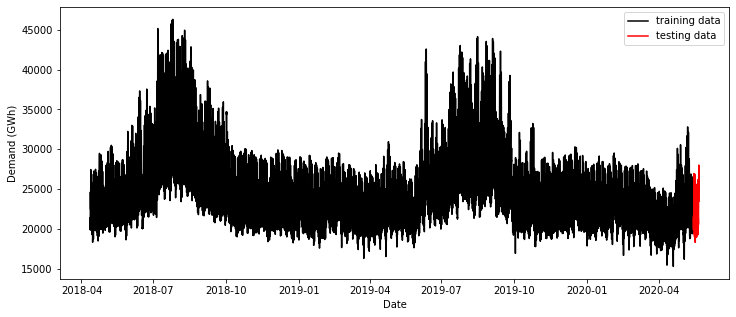

In [4]:
# filling missing values with mean demand
series = mwh['demand'].fillna(np.mean(mwh['demand']))

# train test split, training set is all but one week, testing set is last week of series
train,test = series[:24*7*-1], series[24*7*-1:]

# plot training and testing sets
plt.figure(figsize=(12,5))
plt.plot(train.index,train,'k-',label='training data')
plt.plot(test.index,test,'r-',label='testing data')
plt.xlabel('Date')
plt.ylabel('Demand (GWh)')
plt.legend();

### Instantiate and run AR model

In [15]:
# instantiate and fit model
model = AutoReg(train,lags=24*13)
model_fit = model.fit()

# generate predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

### Visualize results

RMSE = 1129.9214929571235


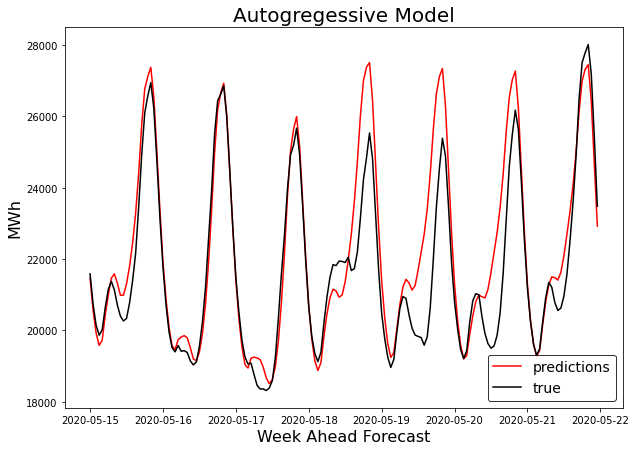

In [16]:
print(f"RMSE = {np.sqrt(mean_squared_error(test, predictions))}")

plt.figure(figsize=(10,7))
plt.plot(predictions,'r',label='predictions')
plt.plot(test,'k',label='true')
plt.xlabel('Week Ahead Forecast',fontsize=16)
plt.ylabel('MWh',fontsize=16)
plt.title('Autogregessive Model',fontsize=20)
plt.legend(fontsize=14,loc='lower right',edgecolor='k');

### Write predictions to file

In [8]:
predictions.to_csv('../datasets/demand_predictions.csv')